In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Part 1 - Quantization

In [4]:
def load_image_as_array(image_path):
    # load the image into numpy array
    with Image.open(image_path) as img:
        img_array = np.array(img)
    return img_array
img_arr = load_image_as_array("rhino.jpg").flatten()

array([186, 182, 178, ...,  79,  79,  80], dtype=uint8)

Histogram of the Image pixels

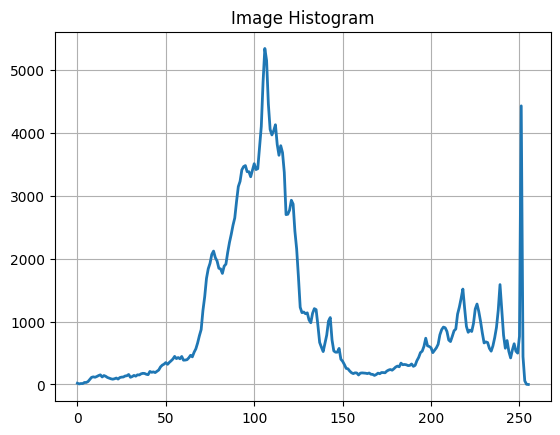

In [30]:
def create_histogram(img_arr):
    hist = np.zeros(256)
    for pixel in img_arr:
        hist[pixel] += 1
    return hist

plt.figure(1)
plt.clf()
plt.title("Image Histogram")

hist = create_histogram(img_arr)
indexes = np.arange(len(hist))

_ = plt.plot(indexes, hist, lw=2)
plt.grid()

Uniform Quantization - 2.a

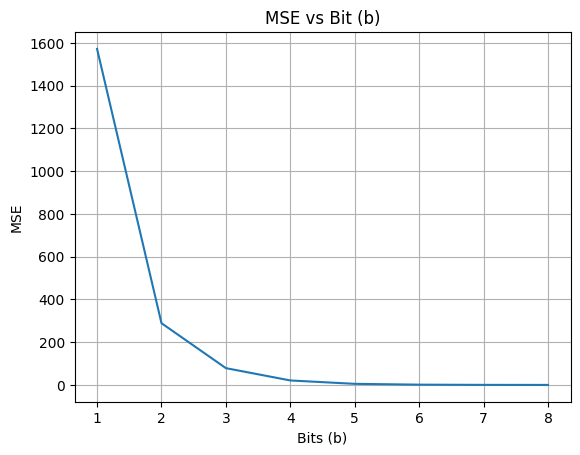

In [13]:
def uniform_quantization(image, b):
    levels = 2**b
    quantization_step = (image.max() - image.min()) / levels
    quantized_image = np.zeros_like(image, dtype=np.uint8)
    interval_entries_array = np.floor((image - image.min())/quantization_step)
    quantized_image = image.min() + (interval_entries_array+0.5)*quantization_step
    mse = np.mean((image - quantized_image)**2)
    return quantized_image, mse

def perform_quantization_for_bits(image, bit_budgets):
    mse_values = np.zeros_like(bit_budgets, dtype=float)
    q_images = []
    # Perform uniform quantization for each bit budget
    for i, b in enumerate(bit_budgets):
        quantized_image, mse = uniform_quantization(image, b)
        q_images.append(quantized_image)
        mse_values[i] = mse
    return mse_values, q_images

bit_budgets = range(1,9)
mse_values, _ = perform_quantization_for_bits(img_arr, bit_budgets)
plt.plot(bit_budgets, mse_values)
plt.title('MSE vs Bit (b)')
plt.xlabel('Bits (b)')
plt.ylabel('MSE')
plt.xticks(bit_budgets)
plt.grid(True)

Decision & Representation Levels Plot - 2b

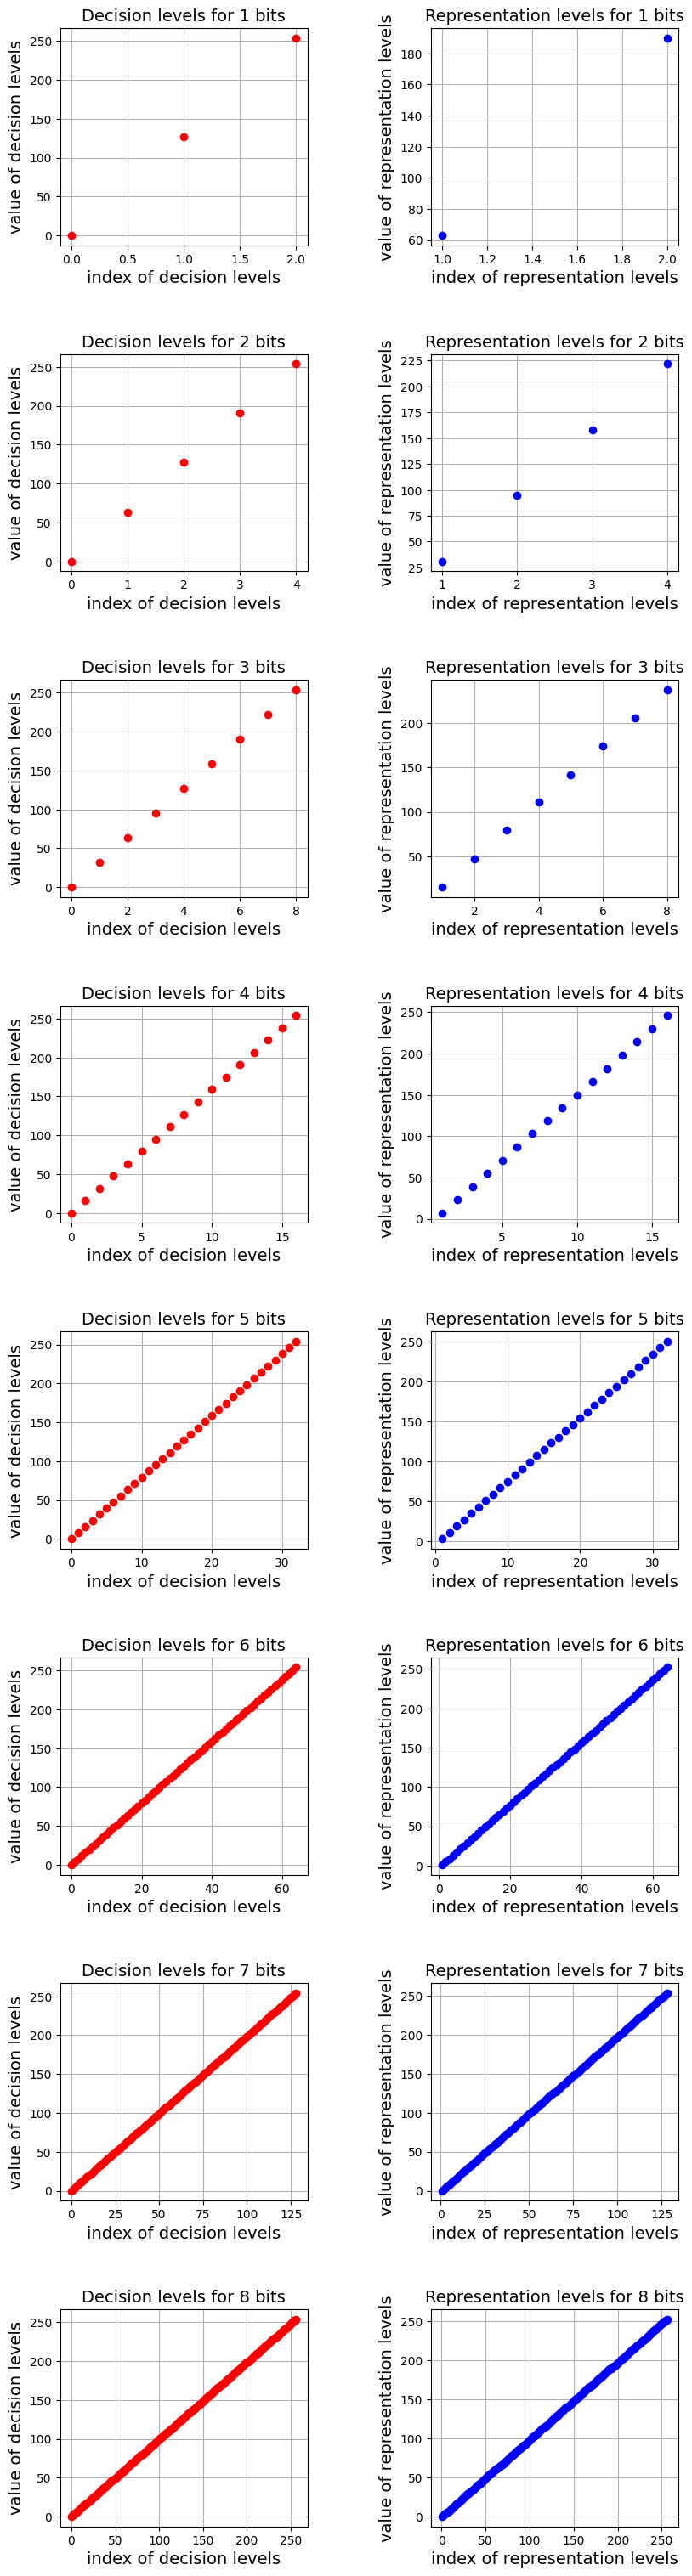

In [16]:
def calculate_uniform_quantization_levels_per_bit(img_arr, b):
  Delta = (img_arr.max() - img_arr.min())/(2**b) # size of single interval
  decision_levels = np.zeros(2**b+1, dtype=np.float64)
  repr_levels = np.zeros(2**b, dtype=np.uint)

  # calculate each array values according to the lecture:
  for i in range(0, 2**b+1) :
    decision_levels[i] = img_arr.min() + i*Delta

  for i in range(0, 2**b) :
    repr_levels[i] = img_arr.min() + (i+0.5)*Delta

  return decision_levels, repr_levels

# set up plot size (8 bits by 2 images (decision and representation))
fig, ax = plt.subplots(8, 2, figsize=(8, 30))
plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for b in bit_budgets:
    # calculate decision and representation levels for each bit limitation
    decision_levels, repr_levels = calculate_uniform_quantization_levels_per_bit(img_arr, b)

    # plot the decision levels
    ax[b-1,0].plot(range(0,(2**b)+1), decision_levels, "ro")
    ax[b-1,0].set_title("Decision levels for " + str(b) + " bits" , fontsize = 14)
    ax[b-1,0].set_xlabel("index of decision levels", fontsize = 14)
    ax[b-1,0].set_ylabel("value of decision levels", fontsize = 14)
    ax[b-1,0].grid()
    # ax.show()

    #plot representation levels:
    ax[b-1,1].plot(range(1,(2**b)+1), repr_levels, "bo")
    ax[b-1,1].set_title("Representation levels for " + str(b) + " bits", fontsize = 14)
    ax[b-1,1].set_xlabel("index of representation levels", fontsize = 14)
    ax[b-1,1].set_ylabel("value of representation levels", fontsize = 14)
    ax[b-1,1].grid()

Max Lloyd Algorithm Implementation - 3

In [18]:
def calculate_representation_levels(hist, decision_levels):
  prob = hist/hist.sum()
  x_prob = np.array([x*prob[x] for x in range(0,prob.size)])
  representation_levels = np.zeros(decision_levels.size-1, dtype=int)
  for i in range(0,representation_levels.size):
    start = int(np.ceil(decision_levels[i]))
    end = int(np.ceil(decision_levels[i+1]))
    sum_xprob = np.sum(x_prob[start:end])
    sum_prob  =np.sum(prob[start:end])
    if sum_xprob==0 or sum_prob==0:
      representation_levels[i] = (int(decision_levels[i]+decision_levels[i+1]))/2
    else:
      representation_levels[i] = sum_xprob / sum_prob
  return representation_levels

def calculate_decision_levels(repr_levels, decision_levels):
  # as we saw in the lacture:
  for i in range(1,decision_levels.size-1): # the first and last decision levels remain the same
    decision_levels[i] = (repr_levels[i-1]+repr_levels[i])/2
  return decision_levels

def calculate_MSE(hist, repr_levels, num_samples):
  mse = 0
  for x in range(0,hist.size):
    squared_error = ((repr_levels-x)**2).min()
    mse += hist[x]*squared_error
  mse /= num_samples
  return mse

In [19]:
def run_max_lloyd(hist, decision_levels, epsilon=0.001):
  num_of_samples = np.sum(hist)
  repr_levels=calculate_representation_levels(hist,decision_levels)
  old_mse = calculate_MSE(hist, repr_levels, num_of_samples)
  while True:
    decision_levels=calculate_decision_levels(repr_levels, decision_levels)
    repr_levels=calculate_representation_levels(hist,decision_levels)
    new_mse = calculate_MSE(hist, repr_levels, num_of_samples)
    # stopping conditional
    if np.abs(new_mse - old_mse) < epsilon:
      return decision_levels, repr_levels, new_mse
    old_mse = new_mse

Apply Max Lloyd Algorithm & Plot MSE vs Bit- 4a

range(1, 9)


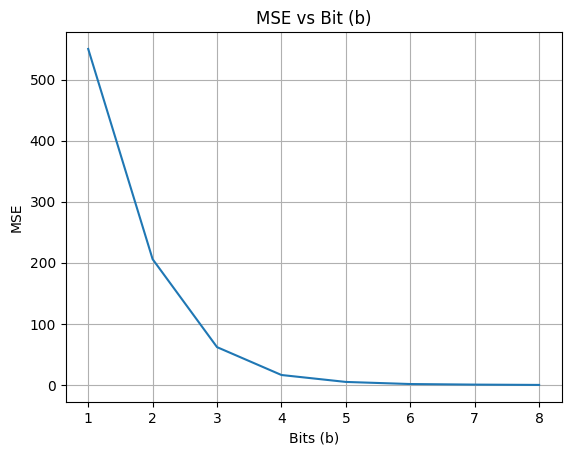

In [36]:
max_lloyd_mse_values = []
# create uniform quantization decision levels
for b in bit_budgets:
    decision_levels, _ = calculate_uniform_quantization_levels_per_bit(img_arr, b)
    decision_levels, repr_levels, mse = run_max_lloyd(hist, decision_levels)
    max_lloyd_mse_values.append(mse)

# plot mse vs. num of bits
print(bit_budgets)
plt.plot(bit_budgets, max_lloyd_mse_values)
plt.title('MSE vs Bit (b)')
plt.xlabel('Bits (b)')
plt.ylabel('MSE')
plt.xticks(bit_budgets)
plt.grid(True)

Plot Decision & Representation Levels - 4b

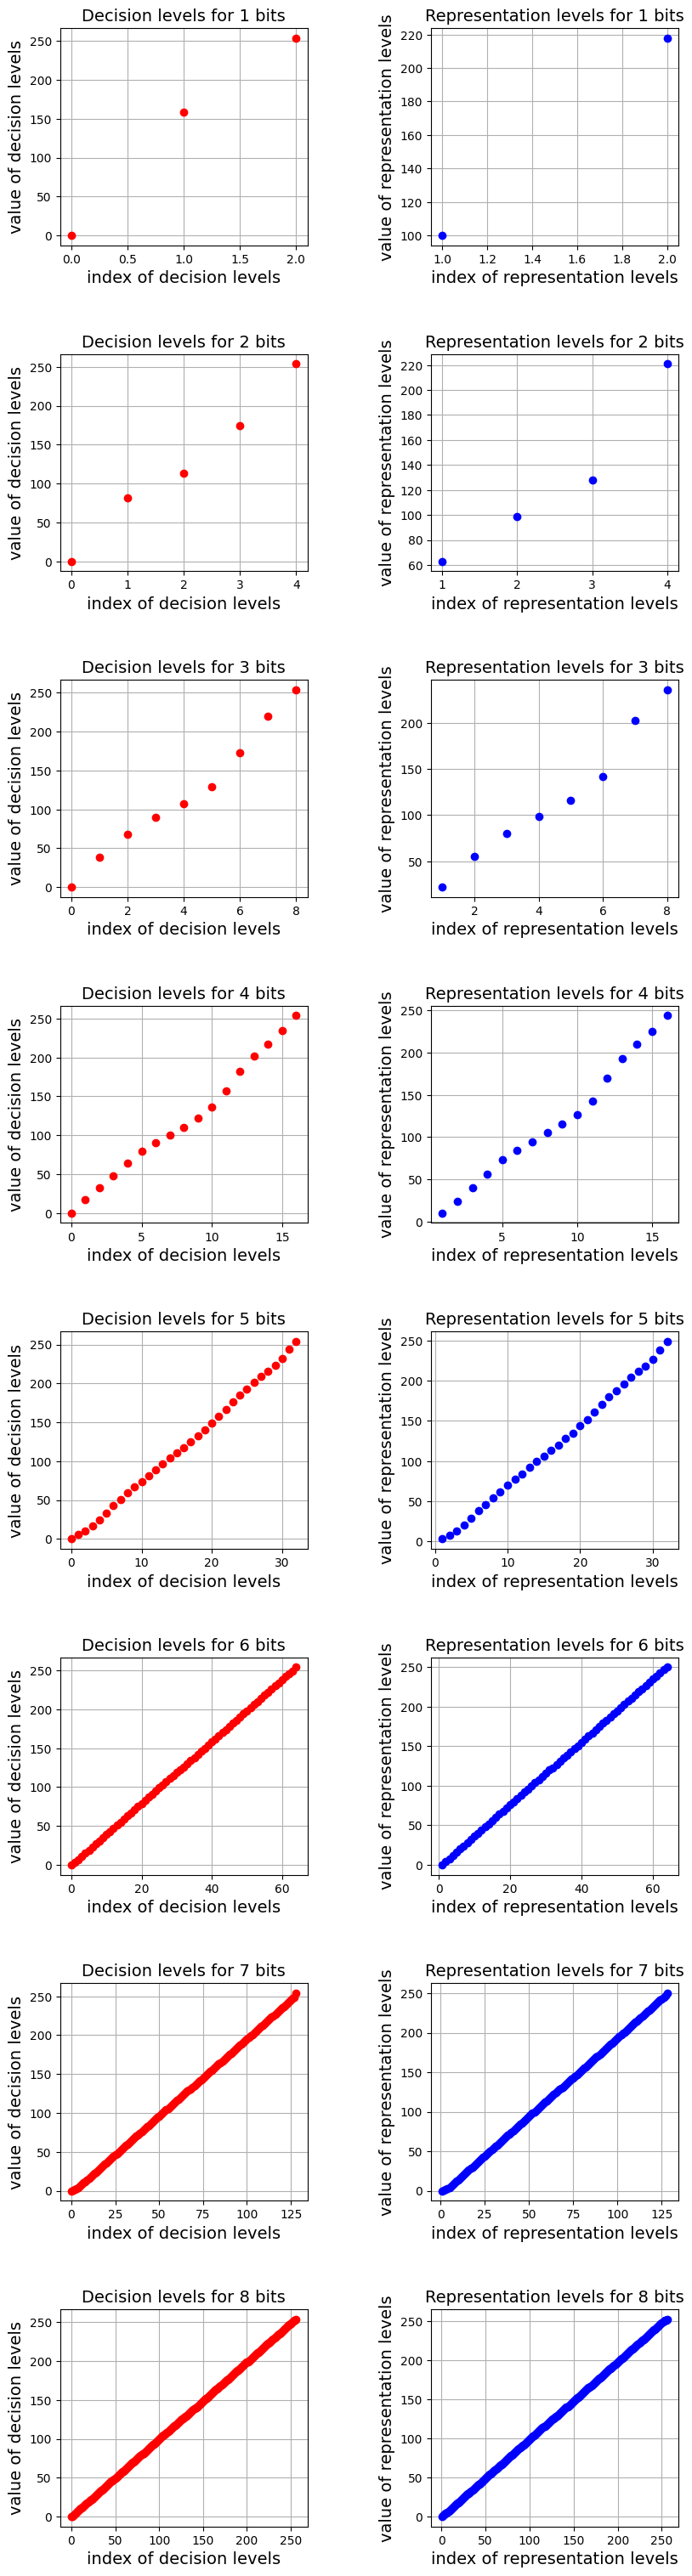

In [38]:
fig, ax = plt.subplots(8, 2, figsize=(8, 30))
plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for b in bit_budgets:
    # calculate decision and representation levels for each bit limitation
    decision_levels, _ = calculate_uniform_quantization_levels_per_bit(img_arr, b)

    # run max-lloyd and calculate new representation and decision levels
    decision_levels, repr_levels, _ = run_max_lloyd(hist, decision_levels)

    # plot the decision levels
    ax[b-1,0].plot(range(0,(2**b)+1), decision_levels, "ro")
    ax[b-1,0].set_title("Decision levels for " + str(b) + " bits" , fontsize = 14)
    ax[b-1,0].set_xlabel("index of decision levels", fontsize = 14)
    ax[b-1,0].set_ylabel("value of decision levels", fontsize = 14)
    ax[b-1,0].grid()
    # ax.show()

    #plot representation levels:
    ax[b-1,1].plot(range(1,(2**b)+1), repr_levels, "bo")
    ax[b-1,1].set_title("Representation levels for " + str(b) + " bits", fontsize = 14)
    ax[b-1,1].set_xlabel("index of representation levels", fontsize = 14)
    ax[b-1,1].set_ylabel("value of representation levels", fontsize = 14)
    ax[b-1,1].grid()

Section 2 - Subsampling & Reconstruction